# Analyzing runs on 18-JAN-2023

- Used the learning rate finder in pytorch-lightning instead of a multi-epoch run with ray-tune
- tried cnn2 & resnet18 on mnist and cifar10

In [13]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
results_dir = "/home/alex/hparam_results"

def build_results_from_dir(path):
    
    results_files = os.listdir(path)
    cols = ['dataset_id', 'model_id', 'split_id', 'split_perc', 'avg_lr', 'std_lr', 'num_samples']
    data = []
    idx = 0
    for res in results_files:
        with open(os.path.join(results_dir, res), "r") as f:
            for r in json.load(f):
                r['avg_lr'] = np.nanmean(r['best_lrs'])
                r['std_lr'] = np.nanstd(r['best_lrs'])
                r['num_samples'] = len(r['best_lrs'])
                r.pop('best_lrs')
                df = pd.DataFrame.from_dict({idx: r}, orient='index')
                data.append(df)
                idx += 1
    data = pd.concat(data)
    return data

In [58]:
df = build_results_from_dir(results_dir)
df.loc[df['model_id']=='pytorch_classifier', 'model_id'] = 'resnet18'
df.head()

,dataset_id,model_id,split_id,split_perc,avg_lr,std_lr,num_samples
0,mnist,cnn2,mnist,100,0.013158,0.018262,10
1,mnist,cnn2,mnist_0_75,75,0.007240,0.007759,10
2,mnist,cnn2,mnist_0_5,50,0.002437,0.000593,10
3,mnist,cnn2,mnist_0_25,25,0.009200,0.011198,10
4,mnist,cnn2,mnist_0_1,10,0.008207,0.010636,10


In [83]:
df['run_id'] = df['model_id'] + "_" + df['dataset_id']

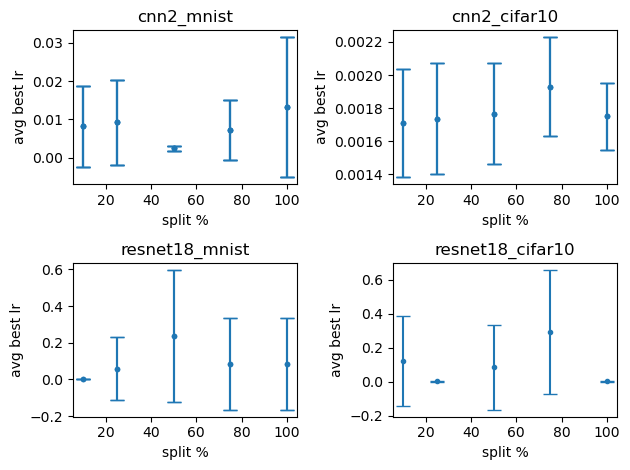

In [95]:
fig, axes = plt.subplots(nrows=2, ncols=2)

for ax, run_id in zip(axes.flatten(), df['run_id'].unique()):
    df_filt = df[df['run_id']==run_id] 
    ax.errorbar(x=df_filt['split_perc'],
                y=df_filt['avg_lr'],
                label=run_id,
                yerr=df_filt['std_lr'],
                capsize=5,
                marker='.',
                linestyle='')
    ax.set_title(run_id)
    ax.set_xlabel("split %")
    ax.set_ylabel("avg best lr")
   # ax.set_ylim([0, 0.01])
fig.tight_layout()

# Conclusions:

- results are too varied to be able to say anything: may want to try 100 samples instead of 10

- pytorch-lightning's learning rate finder may not be appropriate for this kind of experiment - should revisit a multi-epoch training.